In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker
import numpy as np
import importlib
import xarray as xr
import nc_time_axis
import cmocean
import cmocean.cm as cmo
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.patches import Patch, Polygon
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, BboxPatch, BboxConnector,\
    BboxConnectorPatch, zoomed_inset_axes, mark_inset
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import shapely.geometry as sgeom
from matplotlib.lines import Line2D as Line
from matplotlib.patheffects import Stroke
import mpl_toolkits.axes_grid1.inset_locator as il
import cv2
import glob
import nc_time_axis
from eofs.xarray import Eof
import scipy.signal as sps
import scipy.linalg as spl
from scipy import stats
from matplotlib import gridspec
from scipy.signal import butter, lfilter
from functools import partial
from matplotlib.lines import Line2D

from statsmodels.tsa.seasonal import STL
import pandas as pd
from scipy.integrate import odeint
import _pickle as cPickle
import os,sys
from matplotlib.font_manager import FontProperties
import string
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import dask
import pathlib
import random
import os

import ultraplot as pplt

import statsmodels.stats.multitest as multitest

In [4]:
def ds_select(ds,times,params):
    
    times_idx = times[params]
    
    ds_ = ds.rename({'time':'year'})
    ds_['year'] = -np.arange(0,4800012,1)[::-1]/12*5/1000
    
    ds_selected = ds_.where(params, drop=True)
    
    ds_time = xr.DataArray(
    ds_selected,#.where(mask_array==2),
    coords={
        'time': times_idx,
        'lon': ds_selected['lon'],
        'lat': ds_selected['lat'],
    },
    dims=('time', 'lat', 'lon'),
    )
    


    return ds_time#, ds_time.groupby('time.month').quantile(q=0.75,dim='time') #ds_time.groupby('time.month').mean(dim='time')

def ds_select_std(ds,times,params):
    
    times_idx = times[params]
    
    ds_ = ds.rename({'time':'year'})
    ds_['year'] = -np.arange(0,4800012,1)[::-1]/12*5/1000
    
    ds_selected = ds_.where(params, drop=True)
    
    ds_time = xr.DataArray(
    ds_selected,#.where(mask_array==2),
    coords={
        'time': times_idx,
        'lon': ds_selected['lon'],
        'lat': ds_selected['lat'],
    },
    dims=('time', 'lat', 'lon'),
    )
    
    return ds_time.groupby('time.month').std()

def ds_select_std_idx(temp,times,params,mask_array=None,name='DMI'):
    
    times_idx = times[params]
    
    temp_ = temp.rename({'time':'year'})
    temp_['year'] = -np.arange(0,4800012,1)[::-1]/12*5/1000
    temp_selected = temp_.where(params, drop=True)
    
    if name=='DMI':
        val = DMI(temp_selected.where(mask_array==2))
    elif name == 'NINO34':
        val = NINO34(temp_selected.where(mask_array==2))
    elif name == 'WIO':
        val = WIO(temp_selected.where(mask_array==2))
    elif name == 'EIO':
        val = EIO(temp_selected.where(mask_array==2))
    else:
        print('ERROR!')
    
    ds_time = xr.DataArray(
    val,#.where(mask_array==2),
    coords={
        'time': times_idx,
        #'lon': ds_selected['lon'],
        #'lat': ds_selected['lat'],
    },
    dims=('time'),
    )
    
    print(ds_time.groupby('time.month').std())
    
    return ds_time.groupby('time.month').std()

In [5]:
def anom(ds):
    
    ds_clim = ds.groupby('time.month').mean(dim='time')
    ds_anom = ds.groupby('time.month') - ds_clim
    
    return ds_anom

def standardise(ds):
    return (ds - ds.mean())/ds.std()

def NINO34_idx(sst,time='time'):
    
    if sst.lat.values[0] < 0:
        sst = sst.sel(lat=slice(-6,6),lon=slice(360-170,360-120))
    else:
        sst = sst.sel(lat=slice(6,-6),lon=slice(360-170,360-120))
        
    nino34 = sst.mean(dim=('lat','lon'))
    
    return anom(nino34)

def NINO34(sst,model=None,time='time'):
    
    if sst.lat.values[0] < 0:
        sst = sst.sel(lat=slice(-6,6),lon=slice(360-170,360-120))
    else:
        sst = sst.sel(lat=slice(6,-6),lon=slice(360-170,360-120))

    return sst.mean(dim=('lat','lon'))

def EIO(sst,model=None,time='time'):
    
    if sst.lat.values[0] < 0:
        sst_EIO = sst.sel(lat=slice(-11,0),lon=slice(90,110))
    else:
        sst_EIO = sst.sel(lat=slice(0,-11),lon=slice(90,110))

    return sst_EIO.mean(dim=('lat','lon'))

def WIO(sst,model=None,time='time'):
    
    if sst.lat.values[0] < 0:
        sst_WIO = sst.sel(lat=slice(-11,11),lon=slice(50,70))
    else:
        sst_WIO = sst.sel(lat=slice(11,-11),lon=slice(50,70))

    return sst_WIO.mean(dim=('lat','lon'))

def DMI(sst,model=None,time='time'):
    
    sst_DMI = WIO(sst) - EIO(sst)
    
    return sst_DMI

def DMI_idx(ds):
    return anom(WIO(ds)) - anom(EIO(ds))

In [6]:
def calculate_mean_confidence_intervals(ds_time, N=10000, confidence=0.95, mask_array=None):

    dct = {}

    regions = [NINO34,DMI,WIO,EIO]
    regions_names = ['NINO34','DMI','WIO','EIO']

    for index_function,index_name in zip(regions,regions_names):

        mean_values = {month: [] for month in range(1, 13)}
        yr_mean_values = []

        for _ in range(N):
            
            idx = np.random.choice(np.arange(ds_time.shape[0]), size=int(12*1000/5), replace=True)

            if mask_array is not None:
                monthly_mean = index_function(ds_time[idx].where(mask_array==2)).groupby('time.month').mean()
                yr_mean_values.append(monthly_mean.mean().values)
            else:
                monthly_mean = index_function(ds_time[idx]).groupby('time.month').mean()
                yr_mean_values.append(monthly_mean.mean().values)
            
            for month in range(1, 13):
                mean_values[month].append(monthly_mean.sel(month=month).values)

        lower_percentile = (1 - confidence) / 2
        upper_percentile = 1 - lower_percentile

        lower_bounds = {}
        upper_bounds = {}
        means = {}

        for month in range(1, 13):
            lower_bounds[month] = np.percentile(mean_values[month], lower_percentile * 100)
            upper_bounds[month] = np.percentile(mean_values[month], upper_percentile * 100)
            means[month] = np.nanmean(mean_values[month])

        yr_mean_values = np.array(yr_mean_values)

        lower_bounds_yr = np.percentile(yr_mean_values, lower_percentile * 100)
        upper_bounds_yr = np.percentile(yr_mean_values, upper_percentile * 100)
        means_yr = np.nanmean(yr_mean_values)

        dct[f'{index_name}'] = { 
            'lonlat': ds_time[idx].groupby('time.month').mean(),
            'month': {
                'all': means,
                'up': upper_bounds,
                'down': lower_bounds
            },
            'year': {
                'all': means_yr,
                'up': upper_bounds_yr,
                'down': lower_bounds_yr
            }
        }

    return dct

def calculate_std_confidence_intervals(ds_time, N=10000, confidence=0.95, mask_array=None):

    dct = {}

    regions = [NINO34,DMI,WIO,EIO]
    regions_names = ['NINO34','DMI','WIO','EIO']

    for index_function,index_name in zip(regions,regions_names):

        std_values = {month: [] for month in range(1, 13)}
        yr_std_values = []

        for _ in range(N):
            
            idx = np.random.choice(np.arange(ds_time.shape[0]), size=int(12*1000/5), replace=True)

            if mask_array is not None:
                monthly_std = index_function(ds_time[idx].where(mask_array==2)).groupby('time.month').std()
                yr_std_values.append(monthly_std.mean().values)
            else:
                monthly_std = index_function(ds_time[idx]).groupby('time.month').std()
                yr_std_values.append(monthly_std.mean().values)
            
            for month in range(1, 13):
                std_values[month].append(monthly_std.sel(month=month).values)

        lower_percentile = (1 - confidence) / 2
        upper_percentile = 1 - lower_percentile

        lower_bounds = {}
        upper_bounds = {}
        means = {}

        for month in range(1, 13):
            lower_bounds[month] = np.percentile(std_values[month], lower_percentile * 100)
            upper_bounds[month] = np.percentile(std_values[month], upper_percentile * 100)
            means[month] = np.nanmean(std_values[month])

        yr_std_values = np.array(yr_std_values)

        lower_bounds_yr = np.percentile(yr_std_values, lower_percentile * 100)
        upper_bounds_yr = np.percentile(yr_std_values, upper_percentile * 100)
        means_yr = np.nanmean(yr_std_values)

        dct[f'{index_name}'] = { 
            #'lonlat': index_function(ds_time[idx]).groupby('time.month').std(),
            'month': {
                'all': means,
                'up': upper_bounds,
                'down': lower_bounds
            },
            'year': {
                'all': means_yr,
                'up': upper_bounds_yr,
                'down': lower_bounds_yr
            }
        }

    return dct

In [7]:
def false_rate(model,ref,FDR=.15):

    # significance_kw_sca = stats.kruskal(model, ref, axis=0) #.where(identical != 0)), 
    # _, p = significance_kw_sca

    _, p = stats.ttest_ind(model,ref,axis=0)

    p_temp = model[0].copy()
    p_temp.values = p

    FDR = 0.15

    psorted = p_temp.sortby('lon')
    mt = multitest.multipletests(psorted.values,FDR,method='fdr_bh',is_sorted=True)
    mtrejectRate2 = psorted.copy(data=mt[0])
    mtrejectRate2 = mtrejectRate2.unstack()#.transpose()
    sigmask = np.where(mtrejectRate2==True,1.0,0)
    
    return xr.DataArray(sigmask, dims=["lon"], coords=dict(lon=p_temp.lon ) )

In [8]:
def calculate_mean_confidence_intervals_lonlat(ds_time, mon = None, szn = None, year = None, N = 10000, confidence = 0.95):

    ds_time = ds_time.copy(deep=True)

    ds = xr.zeros_like(ds_time[:int(N)].squeeze())

    yr_mean_values = ds.copy(deep=True)

    if mon is not None:
        mean_values = {month: ds.copy(deep=True) for month in ['DJF','MAM','JJA','SON']}

    else:
        mean_values = {month: ds.copy(deep=True) for month in range(1, 13)}

    for _ in range(N):
            
        idx = np.random.choice(np.arange(ds_time.shape[0]), size=int(12*1000/5), replace=True)
        
        #print(ds_time.isel(time=idx).groupby('time.month').mean())

        monthly_mean = ds_time.isel(time=idx).groupby('time.month').mean()

        #yr_mean_values[_] = ds_time.isel(time=idx).groupby('time.year').mean().mean('year')
        yr_mean_values[_] = monthly_mean.mean('month').values
        
        if mon is not None :

            for n,month in zip([ [1,2,12], [3,4,5], [6,7,8], [9,10,11]], ['DJF','MAM','JJA','SON'] ):

                if szn is not None:
                    mean_values[month][_] = monthly_mean.sel(month=n).mean('month') - yr_mean_values[_]

                else :
                    mean_values[month][_] = monthly_mean.sel(month=n).mean('month')
        else :

            for month in range(1, 13):

                if szn is not None:
                    mean_values[month][_] = monthly_mean.sel(month=month) - yr_mean_values[_]

                else :
                    mean_values[month][_] = monthly_mean.sel(month=month)

    if mon is not None :
        ds_month = xr.zeros_like(ds_time[0:1200].groupby('time.month').mean().squeeze())[:4]
        mn = xr.Dataset( { 'mn' : ds_month.copy(deep=True, data = [mean_values[i].mean('time') for i in mean_values.keys()] ) } )
        mask = xr.Dataset( {'mask' : ds_month.copy(deep=True, data= xr.where( 
            [ (mean_values[i].std(dim='time')/mean_values[i].std(dim='time').sum()*100) > \
            (mean_values[i].std(dim='time')/mean_values[i].std(dim='time').sum()*100).mean() for i in mean_values.keys()], 1, 0)) } )

    else :
        ds_month = xr.zeros_like(ds_time[0:1200].groupby('time.month').mean().squeeze())
        mn = xr.Dataset( { 'mn' : ds_month.copy(deep=True, data=[mean_values[i].mean('time') for i in mean_values.keys()]) } )
        mask = xr.Dataset( {'mask' : ds_month.copy(deep=True, data= xr.where( 
            [ (mean_values[i].std(dim='time')/mean_values[i].std(dim='time').sum()*100) > \
            (mean_values[i].std(dim='time')/mean_values[i].std(dim='time').sum()*100).mean() for i in mean_values.keys()], 1, 0)) } )

    if year is not None :
        ds_month = xr.zeros_like(ds_time[0].squeeze())
        yr_mn = xr.Dataset( { 'yr_mn' : ds_month.copy(deep=True, data=yr_mean_values.mean('time')) } )
        yr_mask = xr.Dataset( {'yr_mask' : ds_month.copy(deep=True, data=xr.where((yr_mean_values.std(dim='time')/yr_mean_values.std(dim='time').sum()*100) > \
            (yr_mean_values.std(dim='time')/yr_mean_values.std(dim='time').sum()*100).mean(), 1, 0)) } )
    else : 
        pass
        
    if year is not None:
        return xr.merge([mn, mask, yr_mn, yr_mask])
    else:
        return xr.merge([mn, mask])

In [9]:
temp_adj = xr.open_dataset('variables/adjusted/TS.full.2Ma.mon.masked_monlenadj_hm.nc',decode_times=False)['TS']
mask = xr.open_dataset('variables/pCESM.2Ma_SSH.100yr.nc',decode_times=False).SSH
mask = mask.sel(lon=slice(temp_adj.lon.min().values,temp_adj.lon.max().values),
               lat=slice(temp_adj.lat.min().values,temp_adj.lat.max().values))
mask_ocean = 2 * np.ones((len(mask.coords['lat']), len(mask.coords['lon']))) * np.isfinite(mask[0])  
mask_land = 1 * np.ones((len(mask.coords['lat']), len(mask.coords['lon']))) * np.isnan(mask[0])  
mask_array = mask_ocean + mask_land

In [10]:
params_ = xr.open_dataset('variables/pCESM.2Ma_orbPara.nc')
params = params_.interp(year=-np.arange(0,4800012,1)[::-1]/12*5/1000)

In [11]:
df = pd.read_csv("variables/pCESM.2Ma_orbPara.txt", sep="\s+", header=None)
ds_orb = df.to_xarray().rename({'index':'time'})#.isel(time=slice(None, None, -1))
ds_orb['time'] = ds_orb[0]

In [12]:
df_co2 = pd.read_csv("variables/Insol_GHG_d18o_0ka_2000.txt", sep="\s+", header=None)
ds_co2 = df_co2.to_xarray().rename({'index':'time'}).isel(time=slice(None, None, -1))
ds_co2['time'] = -ds_co2['time'] 
co2 = ds_co2.interp(time=ds_orb['time'])[2]
co2_ = co2.rename({'time':'year'})
co2_ = co2_.interp(year=-np.arange(0,4800012,1)[::-1]/12*5/1000)

In [21]:
#vals = pd.read_csv('variables/vals.csv')#, index_col=0)

file = open("variables/vals_new.pkl",'rb')
vals = pickle.load(file)

vals

Weighted_angle_95 Weighted_angle_5      Range_high       Range_low
WIO                 358.9            202.7   [25.1, 337.7]  [155.8, 243.8]
EIO                 285.9            140.9  [257.1, 305.2]  [104.5, 174.6]
DMI                 286.1            136.2  [257.5, 309.8]  [107.0, 165.2]
Niño3.4             100.9            290.1   [72.9, 138.9]  [230.5, 308.0]
Niño3               107.2            283.9   [81.5, 134.5]  [237.3, 306.1]
Niño4               352.7            164.3   [32.3, 322.3]  [131.9, 197.7]

### Mask for max range of Niño3.4 & DMI

In [22]:
params_mask_nino34_max = (params.longitude_of_perihelion >= vals.loc['Niño3.4', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3.4', 'Range_high'][1]) 

params_mask_dmi_max = (params.longitude_of_perihelion >= vals.loc['DMI', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['DMI', 'Range_high'][1]) 

params_mask_wio_max = ((params.longitude_of_perihelion >= vals.loc['WIO', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['WIO', 'Range_high'][0]))

In [23]:
params_mask_nino34_max_beforeMPT = (params.longitude_of_perihelion >= vals.loc['Niño3.4', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3.4', 'Range_high'][1]) & (params.year <= -1200)

params_mask_dmi_max_beforeMPT = (params.longitude_of_perihelion >= vals.loc['DMI', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['DMI', 'Range_high'][1]) & (params.year <= -1200)

params_mask_wio_max_beforeMPT = (params.year <= -1200) & ( ((params.longitude_of_perihelion >= vals.loc['WIO', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['WIO', 'Range_high'][0])) )

In [24]:
params_mask_nino34_max_afterMPT = (params.longitude_of_perihelion >= vals.loc['Niño3.4', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3.4', 'Range_high'][1]) & (params.year >= -800)

params_mask_dmi_max_afterMPT = (params.longitude_of_perihelion >= vals.loc['DMI', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['DMI', 'Range_high'][1]) & (params.year >= -800)

params_mask_wio_max_afterMPT = (params.year >= -800) & ( ((params.longitude_of_perihelion >= vals.loc['WIO', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['WIO', 'Range_high'][0])) )

In [25]:
params_mask_nino34_max_beforeMPT_co2max = (params.longitude_of_perihelion >= vals.loc['Niño3.4', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3.4', 'Range_high'][1]) & (co2_ >= np.nanpercentile(co2_[params.year <= -1200],80)) & (params.year <= -1200)

params_mask_nino34_max_beforeMPT_co2min = (params.longitude_of_perihelion >= vals.loc['Niño3.4', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3.4', 'Range_high'][1]) & (co2_ <= np.nanpercentile(co2_[params.year <= -1200],20)) & (params.year <= -1200)

params_mask_dmi_max_beforeMPT_co2max = (params.longitude_of_perihelion >= vals.loc['DMI', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['DMI', 'Range_high'][1]) & (co2_ >= np.nanpercentile(co2_[params.year <= -1200],80)) & (params.year <= -1200)

params_mask_dmi_max_beforeMPT_co2min = (params.longitude_of_perihelion >= vals.loc['DMI', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['DMI', 'Range_high'][1]) & (co2_ <= np.nanpercentile(co2_[params.year <= -1200],20)) & (params.year <= -1200)

params_mask_wio_max_beforeMPT_co2max = (params.year <= -1200) & ( ((params.longitude_of_perihelion >= vals.loc['WIO', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['WIO', 'Range_high'][0])) ) & (co2_ >= np.nanpercentile(co2_[params.year <= -1200],80)) & (params.year <= -1200)

params_mask_wio_max_beforeMPT_co2min = (params.year <= -1200) & ( ((params.longitude_of_perihelion >= vals.loc['WIO', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['WIO', 'Range_high'][0])) ) & (co2_ <= np.nanpercentile(co2_[params.year <= -1200],20)) & (params.year <= -1200)

In [26]:
params_mask_nino34_max_afterMPT_co2max = (params.longitude_of_perihelion >= vals.loc['Niño3.4', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3.4', 'Range_high'][1]) & (co2_ >= np.nanpercentile(co2_[params.year >= -800],80)) & (params.year >= -800)

params_mask_nino34_max_afterMPT_co2min = (params.longitude_of_perihelion >= vals.loc['Niño3.4', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3.4', 'Range_high'][1]) & (co2_ <= np.nanpercentile(co2_[params.year >= -800],20)) & (params.year >= -800)

params_mask_dmi_max_afterMPT_co2max = (params.longitude_of_perihelion >= vals.loc['DMI', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['DMI', 'Range_high'][1]) & (co2_ >= np.nanpercentile(co2_[params.year >= -800],80)) & (params.year >= -800)

params_mask_dmi_max_afterMPT_co2min = (params.longitude_of_perihelion >= vals.loc['DMI', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['DMI', 'Range_high'][1]) & (co2_ <= np.nanpercentile(co2_[params.year >= -800],20)) & (params.year >= -800)

params_mask_wio_max_afterMPT_co2max = (params.year >= -800) & ( ((params.longitude_of_perihelion >= vals.loc['WIO', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['WIO', 'Range_high'][0])) ) & (co2_ >= np.nanpercentile(co2_[params.year >= -800],80)) & (params.year >= -800)

params_mask_wio_max_afterMPT_co2min = (params.year >= -800) & ( ((params.longitude_of_perihelion >= vals.loc['WIO', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['WIO', 'Range_high'][0])) ) & (co2_ <= np.nanpercentile(co2_[params.year >= -800],20)) & (params.year >= -800)

In [27]:
params_mask_nino4_max = ((params.longitude_of_perihelion >= vals.loc['Niño4', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['Niño4', 'Range_high'][0]))

params_mask_nino4_max_beforeMPT = (params.year <= -1200) & ( ((params.longitude_of_perihelion >= vals.loc['Niño4', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['Niño4', 'Range_high'][0])) )

params_mask_nino4_max_afterMPT = (params.year >= -800) & ( ((params.longitude_of_perihelion >= vals.loc['Niño4', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['Niño4', 'Range_high'][0])) )

params_mask_nino4_max_beforeMPT_co2max = (params.year <= -1200) & ( ((params.longitude_of_perihelion >= vals.loc['Niño4', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['Niño4', 'Range_high'][0])) ) & (co2_ >= np.nanpercentile(co2_[params.year <= -1200],80)) & (params.year <= -1200)

params_mask_nino4_max_beforeMPT_co2min = (params.year <= -1200) & ( ((params.longitude_of_perihelion >= vals.loc['Niño4', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['Niño4', 'Range_high'][0])) ) & (co2_ <= np.nanpercentile(co2_[params.year <= -1200],20)) & (params.year <= -1200)

params_mask_nino4_max_afterMPT_co2max = (params.year >= -800) & ( ((params.longitude_of_perihelion >= vals.loc['Niño4', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['Niño4', 'Range_high'][0])) ) & (co2_ >= np.nanpercentile(co2_[params.year >= -800],80)) & (params.year >= -800)

params_mask_nino4_max_afterMPT_co2min = (params.year >= -800) & ( ((params.longitude_of_perihelion >= vals.loc['Niño4', 'Range_high'][1]) & (params.longitude_of_perihelion <= 360)) | \
((params.longitude_of_perihelion >= 0) & (params.longitude_of_perihelion <= vals.loc['Niño4', 'Range_high'][0])) ) & (co2_ <= np.nanpercentile(co2_[params.year >= -800],20)) & (params.year >= -800)

In [28]:
params_mask_nino3_max = (params.longitude_of_perihelion >= vals.loc['Niño3', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3', 'Range_high'][1]) 

params_mask_nino3_max_beforeMPT = (params.longitude_of_perihelion >= vals.loc['Niño3', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3', 'Range_high'][1]) & (params.year <= -1200)

params_mask_nino3_max_afterMPT = (params.longitude_of_perihelion >= vals.loc['Niño3', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3', 'Range_high'][1]) & (params.year >= -800)

params_mask_nino3_max_beforeMPT_co2max = (params.longitude_of_perihelion >= vals.loc['Niño3', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3', 'Range_high'][1]) & (co2_ >= np.nanpercentile(co2_[params.year <= -1200],80)) & (params.year <= -1200)

params_mask_nino3_max_beforeMPT_co2min = (params.longitude_of_perihelion >= vals.loc['Niño3', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3', 'Range_high'][1]) & (co2_ <= np.nanpercentile(co2_[params.year <= -1200],20)) & (params.year <= -1200)

params_mask_nino3_max_afterMPT_co2max = (params.longitude_of_perihelion >= vals.loc['Niño3', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3', 'Range_high'][1]) & (co2_ >= np.nanpercentile(co2_[params.year >= -800],80)) & (params.year >= -800)

params_mask_nino3_max_afterMPT_co2min = (params.longitude_of_perihelion >= vals.loc['Niño3', 'Range_high'][0]) & (params.longitude_of_perihelion <= vals.loc['Niño3', 'Range_high'][1]) & (co2_ <= np.nanpercentile(co2_[params.year >= -800],20)) & (params.year >= -800)


##### Variables

In [29]:
!ls variables/adjusted

TS.full.2Ma.mon.masked_monlenadj_hm.nc
imonth_lengths_2Ma_ann_palinsol_ber78.csv
prect.full.2Ma.mon_monlenadj_hm.nc
rmonth_lengths_2Ma_ann_palinsol_ber78.csv
solin.full.2Ma.mon_monlenadj_hm.nc
taux.full.2Ma.mon_monlenadj_hm.nc
tauy.full.2Ma.mon_monlenadj_hm.nc
thermocline.full.2Ma.mon_monlenadj_hm.nc


In [30]:
temp = xr.open_dataset('variables/adjusted/TS.full.2Ma.mon.masked_monlenadj_hm.nc', decode_times=False)['TS']
prect = xr.open_dataset('variables/adjusted/prect.full.2Ma.mon_monlenadj_hm.nc', decode_times=False)['PRECT']
solin = xr.open_dataset('variables/adjusted/solin.full.2Ma.mon_monlenadj_hm.nc', decode_times=False)['SOLIN']
taux = xr.open_dataset('variables/adjusted/taux.full.2Ma.mon_monlenadj_hm.nc', decode_times=False)['TAUX']
tauy = xr.open_dataset('variables/adjusted/tauy.full.2Ma.mon_monlenadj_hm.nc', decode_times=False)['TAUY']
thermocline = xr.open_dataset('variables/adjusted/thermocline.full.2Ma.mon_monlenadj_hm.nc', decode_times=False)['thermocline']


In [31]:
mask = xr.open_dataset('variables/pCESM.2Ma_SSH.100yr.nc',decode_times=False).SSH
mask = mask.sel(lon=slice(temp.lon.min().values,temp.lon.max().values),
               lat=slice(temp.lat.min().values,temp.lat.max().values))

In [32]:
mask_ocean = 2 * np.ones((len(mask.coords['lat']), len(mask.coords['lon']))) * np.isfinite(mask[0])  
mask_land = 1 * np.ones((len(mask.coords['lat']), len(mask.coords['lon']))) * np.isnan(mask[0])  
mask_array = mask_ocean + mask_land

##### Applying mask to variables

In [ ]:
#times = xr.cftime_range(start="0001-01-01 00:00:00", periods=4800012, freq="1MS", calendar="365_day")

In [33]:
import pickle

# with open('variables/times.pkl', 'wb') as f:
#     pickle.dump(times, f)

with open('variables/times.pkl', 'rb') as f:
    times = pickle.load(f)

In [34]:
mask = [params_mask_nino34_max,params_mask_dmi_max,
        params_mask_nino34_max_beforeMPT,params_mask_dmi_max_beforeMPT,
        params_mask_nino34_max_afterMPT,params_mask_dmi_max_afterMPT,
        params_mask_nino34_max_beforeMPT_co2max,params_mask_nino34_max_beforeMPT_co2min,
        params_mask_dmi_max_beforeMPT_co2max,params_mask_dmi_max_beforeMPT_co2min,
        params_mask_nino34_max_afterMPT_co2max,params_mask_nino34_max_afterMPT_co2min,
        params_mask_dmi_max_afterMPT_co2max,params_mask_dmi_max_afterMPT_co2min]

mask_names = ['NINO34_max','DMI_max',
                'NINO34_max_beforeMPT','DMI_max_beforeMPT',
                'NINO34_max_afterMPT','DMI_max_afterMPT',
                'NINO34_max_beforeMPT_co2max','NINO34_max_beforeMPT_co2min',
                'DMI_max_beforeMPT_co2max','DMI_max_beforeMPT_co2min',
                'NINO34_max_afterMPT_co2max','NINO34_max_afterMPT_co2min',
                'DMI_max_afterMPT_co2max','DMI_max_afterMPT_co2min']
                
ds = [temp]#,solin,prect,taux,tauy,thermocline]
 
ds_names = ['temp']#,'solin','prect','taux','tauy','thermocline']

In [ ]:
mask = [params_mask_nino34_max,params_mask_dmi_max,params_mask_wio_max,
        params_mask_nino34_max_beforeMPT,params_mask_dmi_max_beforeMPT,params_mask_wio_max_beforeMPT,
        params_mask_nino34_max_afterMPT,params_mask_dmi_max_afterMPT,params_mask_wio_max_afterMPT,
        params_mask_nino34_max_beforeMPT_co2max,params_mask_nino34_max_beforeMPT_co2min,
        params_mask_dmi_max_beforeMPT_co2max,params_mask_dmi_max_beforeMPT_co2min,
        params_mask_wio_max_beforeMPT_co2max,params_mask_wio_max_beforeMPT_co2min,
        params_mask_nino34_max_afterMPT_co2max,params_mask_nino34_max_afterMPT_co2min,
        params_mask_dmi_max_afterMPT_co2max,params_mask_dmi_max_afterMPT_co2min,
        params_mask_wio_max_afterMPT_co2max,params_mask_wio_max_afterMPT_co2min,
        params_mask_nino4_max,params_mask_nino4_max_beforeMPT,params_mask_nino4_max_afterMPT,
        params_mask_nino4_max_beforeMPT_co2max,params_mask_nino4_max_beforeMPT_co2min,
        params_mask_nino4_max_afterMPT_co2max,params_mask_nino4_max_afterMPT_co2min,
        params_mask_nino3_max,params_mask_nino3_max_beforeMPT,params_mask_nino3_max_afterMPT,
        params_mask_nino3_max_beforeMPT_co2max,params_mask_nino3_max_beforeMPT_co2min,
        params_mask_nino3_max_afterMPT_co2max,params_mask_nino3_max_afterMPT_co2min]

mask_names = ['NINO34_max','DMI_max','WIO_max',
                'NINO34_max_beforeMPT','DMI_max_beforeMPT','WIO_max_beforeMPT',
                'NINO34_max_afterMPT','DMI_max_afterMPT','WIO_max_afterMPT',
                'NINO34_max_beforeMPT_co2max','NINO34_max_beforeMPT_co2min',
                'DMI_max_beforeMPT_co2max','DMI_max_beforeMPT_co2min',
                'WIO_max_beforeMPT_co2max','WIO_max_beforeMPT_co2min',
                'NINO34_max_afterMPT_co2max','NINO34_max_afterMPT_co2min',
                'DMI_max_afterMPT_co2max','DMI_max_afterMPT_co2min',
                'WIO_max_afterMPT_co2max','WIO_max_afterMPT_co2min',
                'NINO4_max','NINO4_max_beforeMPT','NINO4_max_afterMPT',
                'NINO4_max_beforeMPT_co2max','NINO4_max_beforeMPT_co2min',
                'NINO4_max_afterMPT_co2max','NINO4_max_afterMPT_co2min',
                'NINO3_max','NINO3_max_beforeMPT','NINO3_max_afterMPT',
                'NINO3_max_beforeMPT_co2max','NINO3_max_beforeMPT_co2min',
                'NINO3_max_afterMPT_co2max','NINO3_max_afterMPT_co2min']
                

ds = [temp]#,solin,prect,taux,tauy,thermocline]
 
ds_names = ['temp']#,'solin','prect','taux','tauy','thermocline']

In [ ]:
# for d,dn in zip(ds,ds_names) :

#     print('')
#     print(dn)

#     STD = {}
#     #MEAN = {}
#     # IND = {}
#     # PAC = {}
#     # LONLAT = {}
    
#     for m,mn in zip(mask,mask_names) :

#         print(mn)

#         ds_time = ds_select(d,times,m)

#         ###########################
#         plt.figure(figsize=(15,10))
#         plt.plot(params.year, co2_,color='k')
#         plt.scatter(params.year[m], co2_[m],c='orange')
#         plt.pause(0.2)
#         ###########################

#         if dn == 'temp':
#             STD[f'{mn}'] = calculate_std_confidence_intervals(ds_time, mask_array=mask_array)
#             #MEAN[f'{mn}'] = calculate_mean_confidence_intervals(ds_time, mask_array=mask_array)

#         else :
#             #MEAN[f'{mn}'] = calculate_mean_confidence_intervals(ds_time)
#             pass

#         # if dn == 'temp':
#         #     PAC[f'{mn}'] = calculate_mean_confidence_intervals_lonlat(ds_time.sel(lat=slice(-5,5),lon=slice(115,280)).where(
#         #         mask_array.sel(lat=slice(-5,5),lon=slice(115,280)) == 2).mean('lat'), #mon=True,
#         #     szn=True,year=True)

#         #     IND[f'{mn}'] = calculate_mean_confidence_intervals_lonlat(ds_time.sel(lat=slice(-10,0),lon=slice(50,115)).where(
#         #         mask_array.sel(lat=slice(-10,0),lon=slice(50,115)) == 2).mean('lat'), #mon=True,
#         #     szn=True,year=True)
#         # else:
#         #     PAC[f'{mn}'] = calculate_mean_confidence_intervals_lonlat(ds_time.sel(lat=slice(-5,5),lon=slice(115,280)).mean('lat'), #mon=True,
#         #     szn=True,year=True)

#         #     IND[f'{mn}'] = calculate_mean_confidence_intervals_lonlat(ds_time.sel(lat=slice(-10,0),lon=slice(50,115)).mean('lat'), #mon=True,
#         #     szn=True,year=True)

#         # if dn == 'temp':
#         #     LONLAT[f'{mn}'] = calculate_mean_confidence_intervals_lonlat(ds_time.sel(lon=slice(45,285)).where(
#         #         mask_array.sel(lon=slice(45,285)) == 2), mon=True,
#         #     szn=True,year=True)

#         # else:
#         #     LONLAT[f'{mn}'] = calculate_mean_confidence_intervals_lonlat(ds_time.sel(lon=slice(45,285)), mon=True,
#         #     szn=True,year=True)

#     with open(f'variables/{dn}_STD.pickle', 'wb') as handle:
#         pickle.dump(STD, handle, protocol=pickle.HIGHEST_PROTOCOL)

#     # with open(f'variables/{dn}_MEAN.pickle', 'wb') as handle:
#     #   pickle.dump(MEAN, handle, protocol=pickle.HIGHEST_PROTOCOL)

#     # with open(f'variables/{dn}_PAC.pickle', 'wb') as handle:
#     #     pickle.dump(PAC, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#     # with open(f'variables/{dn}_IND.pickle', 'wb') as handle:
#     #     pickle.dump(IND, handle, protocol=pickle.HIGHEST_PROTOCOL)

#     # with open(f'variables/{dn}_LONLAT.pickle', 'wb') as handle:
#     #     pickle.dump(LONLAT, handle, protocol=pickle.HIGHEST_PROTOCOL)

#     print('saved')

### Reading the variables saved

In [36]:
!ls variables/*.pickle

variables/prect_IND.pickle          variables/tauy_IND.pickle
variables/prect_LONLAT.pickle       variables/tauy_LONLAT.pickle
variables/prect_MEAN.pickle         variables/tauy_MEAN.pickle
variables/prect_PAC.pickle          variables/tauy_PAC.pickle
variables/prect_STD.pickle          variables/tauy_STD.pickle
variables/solin_IND.pickle          variables/temp_IND.pickle
variables/solin_LONLAT.pickle       variables/temp_LONLAT.pickle
variables/solin_MEAN.pickle         variables/temp_MEAN.pickle
variables/solin_PAC.pickle          variables/temp_PAC.pickle
variables/solin_STD.pickle          variables/temp_STD.pickle
variables/taux_IND.pickle           variables/thermocline_IND.pickle
variables/taux_LONLAT.pickle        variables/thermocline_LONLAT.pickle
variables/taux_MEAN.pickle          variables/thermocline_MEAN.pickle
variables/taux_PAC.pickle           variables/thermocline_PAC.pickle
variables/taux_STD.pickle           variables/thermocline_STD.pickle


In [37]:
directory = 'variables/'

pickle_files = [f for f in os.listdir(directory) if f.endswith('.pickle')]

data_dict = {}

for filename in pickle_files:
    file_path = os.path.join(directory, filename)

    with open(file_path, 'rb') as file:
        data = pickle.load(file)

    key = os.path.splitext(filename)[0]
    data_dict[key] = data

for key, value in data_dict.items():
    print(f'Contents of {key}:')
    print(value)
    print('---' * 20)

Contents of temp_MEAN:
{'NINO34_max': {'NINO34': {'lonlat': <xarray.DataArray 'TS' (month: 12, lat: 16, lon: 77)> Size: 59kB
array([[[296.77606, 296.79904, 296.68182, ..., 295.58563, 295.39685,
         295.328  ],
        [298.29776, 298.34372, 298.253  , ..., 296.8268 , 296.88116,
         296.95248],
        [298.79944, 298.1795 , 298.55487, ..., 297.4114 , 297.63644,
         297.78107],
        ...,
        [286.1379 , 285.5987 , 286.8694 , ..., 294.55823, 294.23245,
         293.97336],
        [283.8841 , 282.75616, 289.72357, ..., 293.78488, 293.41217,
         293.09375],
        [280.24634, 286.54276, 283.35654, ..., 292.5793 , 292.3159 ,
         292.0423 ]],

       [[297.6698 , 297.68164, 297.5941 , ..., 296.58112, 296.4589 ,
         296.46286],
        [298.721  , 298.97098, 299.02963, ..., 297.6327 , 297.82614,
         297.96674],
        [298.80237, 298.25293, 299.03842, ..., 298.08054, 298.38904,
         298.47617],
...
        [290.53482, 290.38718, 291.9061 , ...,

In [ ]:
array = [
    [1, 2, 3, 4, 5],
    [0, 6, 7, 8, 9],
    [0, 10, 0, 11, 12]
]

fig, axs = pplt.subplots(
    array,
    refwidth=10,
    share=False
)

s = 1.25
months = np.arange(1, 13)
months_name = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

def plot_data(ax, var, indices, transform=None, label=None):

    hs = []
    for key in ['NINO34_max', 'DMI_max']:
        data = np.array([data_dict[var][key][indices]['month']['all'][i] for i in data_dict[var][key][indices]['month']['all']])
        data_min = np.array([data_dict[var][key][indices]['month']['up'][i] for i in data_dict[var][key][indices]['month']['up']])
        data_max = np.array([data_dict[var][key][indices]['month']['down'][i] for i in data_dict[var][key][indices]['month']['down']])
        if transform:
            data = transform(data)
            data_min = transform(data_min)
            data_max = transform(data_max)
        hs.append(ax.plot(months, data, linewidth=5 * s, label=r'Max DMI $\sigma_{SST}$' if key == 'DMI_max' else r'Max Niño3.4 $\sigma_{SST}$'))
        ax.fill_between(months, data_min, data_max, alpha=0.5)

    return hs

plot_configs = [
    ('solin_MEAN', 'NINO34', None, 'Insolation', [370, 390, 410, 430, 450], (370, 458), 'TOA radiation [W/m$^2$]', None),
    ('temp_MEAN', 'NINO34', lambda x: x - 273.15, 'Niño3.4', [22, 24, 26, 28], (22, 29), 'SST [°C]', None),
    ('temp_MEAN', 'DMI', None, 'WIO $-$ EIO', [-2, -1.5, -1, -0.5, 0, 0.5], (-2, 0.5), None, 0),
    ('temp_MEAN', 'WIO', lambda x: x - 273.15, 'WIO', [22, 24, 26, 28], (22, 29), None, None),
    ('temp_MEAN', 'EIO', lambda x: x - 273.15, 'EIO', [22, 24, 26, 28], (22, 29), None, None),
    ('thermocline_MEAN', 'NINO34', lambda x: x * 0.01, None, None, (80, 140), 'Thermocline depth [m]', None),
    ('thermocline_MEAN', 'DMI', lambda x: x * 0.01, None, None, (-20, 50), None, 0),
    ('thermocline_MEAN', 'WIO', lambda x: x * 0.01, None, None, (80, 140), None, None),
    ('thermocline_MEAN', 'EIO', lambda x: x * 0.01, None, None, (80, 140), None, None),
    ('taux_MEAN', 'NINO34', lambda x: -x, None, [-0.05, -0.025, 0, 0.025], (-0.062, 0.044), r'Zonal wind stress [N/m$^2$]', 0),
    ('taux_MEAN', 'WIO', lambda x: -x, None, [-0.05, -0.025, 0, 0.025], (-0.062, 0.044), None, 0),
    ('taux_MEAN', 'EIO', lambda x: -x, None, [-0.05, -0.025, 0, 0.025], (-0.062, 0.044), None, 0)
]

for ax, (var, region, transform, title, yticks, ylim, ylabel, axhline) in zip(axs, plot_configs):
    hs = plot_data(ax, var, region, transform)
    if title:
        ax.set_title(title, fontweight='bold', fontsize=65, pad=30)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=15, fontsize=55)
    if yticks:
        ax.set_yticks(yticks)
    if axhline is not None:
        ax.axhline(0,linestyle='--',color='k',alpha=.5, linewidth=4)
    ax.set_ylim(ylim)
    ax.set_xticks(months)
    ax.set_xticklabels(months_name)
    ax.tick_params(width=3, pad=15, length=15)
    ax.set_xlim(1, 12)
    
axs[1].legend(hs, loc='upper center', ncol=1, frameon=False)

axs.format(abc='a.', abcloc='ul', titleloc='c', titlepad=20, abctitlepad=10,
            xtickdir='out', ytickdir='out', xtickminor=False, ygridminor=False, ticklen=10)

plt.savefig("szn_max.png", dpi=300, format='png', bbox_inches='tight', transparent=True)

In [38]:
def read_d(d):
    return [d[i] for i in d]

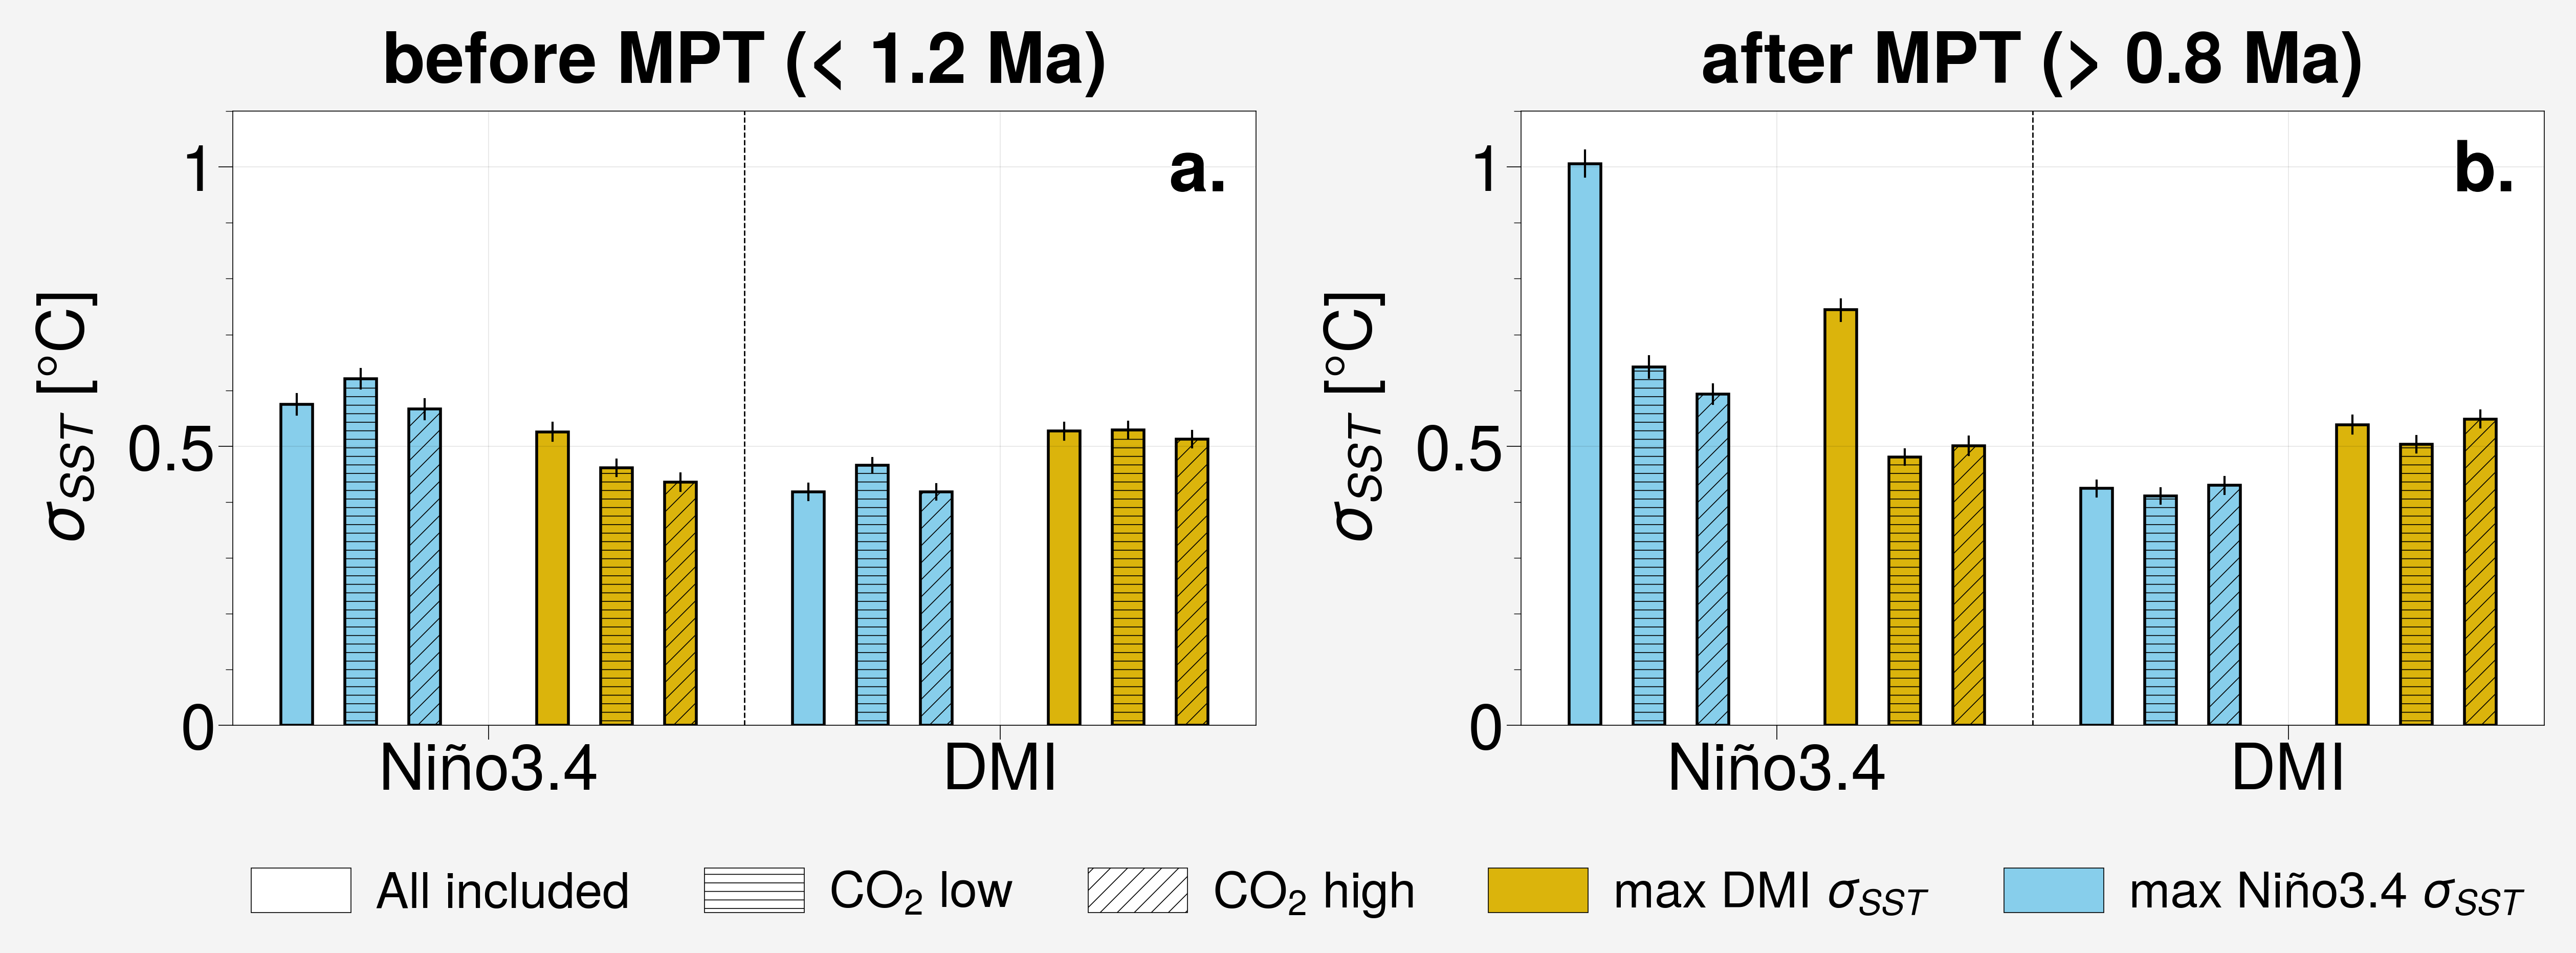

In [129]:
array = [
    [1, 2]
]

fig, axs = pplt.subplots(array, share=0, refwidth=10, refheight=6)

pplt.rc['font.size'] = 45

s = 1.5
months = np.arange(1, 13)
months_name = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
width = 1

##################
# Plotting on ax1
##################

ax1 = axs[0]
 
ax1.axvline(7, color='k', linestyle='--', linewidth=1)

###### before MPT ######

## NINO34

ax1.bar(0, data_dict['temp_STD']['NINO34_max_beforeMPT']['NINO34']['year']['all'], width=width, linewidth=2, edgecolor='k', facecolor='skyblue')
ax1.plot([0, 0], [data_dict['temp_STD']['NINO34_max_beforeMPT']['NINO34']['year']['down'], data_dict['temp_STD']['NINO34_max_beforeMPT']['NINO34']['year']['up'] ], color='k')

ax1.bar(1, data_dict['temp_STD']['NINO34_max_beforeMPT_co2min']['NINO34']['year']['all'], width=width, hatch='--', linewidth=2, edgecolor='k', facecolor='skyblue')
ax1.plot([1, 1], [ data_dict['temp_STD']['NINO34_max_beforeMPT_co2min']['NINO34']['year']['down'], data_dict['temp_STD']['NINO34_max_beforeMPT_co2min']['NINO34']['year']['up'] ], color='k')

ax1.bar(2, data_dict['temp_STD']['NINO34_max_beforeMPT_co2max']['NINO34']['year']['all'], width=width, hatch='//', linewidth=2, edgecolor='k', facecolor='skyblue')
ax1.plot([2, 2], [ data_dict['temp_STD']['NINO34_max_beforeMPT_co2max']['NINO34']['year']['down'], data_dict['temp_STD']['NINO34_max_beforeMPT_co2max']['NINO34']['year']['up'] ], color='k')

#

ax1.bar(4, data_dict['temp_STD']['DMI_max_beforeMPT']['NINO34']['year']['all'], width=width, linewidth=2, edgecolor='k', facecolor='gold')
ax1.plot([4, 4], [ data_dict['temp_STD']['DMI_max_beforeMPT']['NINO34']['year']['down'], data_dict['temp_STD']['DMI_max_beforeMPT']['NINO34']['year']['up'] ], color='k')

ax1.bar(5, data_dict['temp_STD']['DMI_max_beforeMPT_co2min']['NINO34']['year']['all'], width=width, hatch='--', linewidth=2, edgecolor='k', facecolor='gold')
ax1.plot([5, 5], [ data_dict['temp_STD']['DMI_max_beforeMPT_co2min']['NINO34']['year']['down'], data_dict['temp_STD']['DMI_max_beforeMPT_co2min']['NINO34']['year']['up'] ], color='k')

ax1.bar(6, data_dict['temp_STD']['DMI_max_beforeMPT_co2max']['NINO34']['year']['all'], width=width, hatch='//', linewidth=2, edgecolor='k', facecolor='gold')
ax1.plot([6, 6], [ data_dict['temp_STD']['DMI_max_beforeMPT_co2max']['NINO34']['year']['down'], data_dict['temp_STD']['DMI_max_beforeMPT_co2max']['NINO34']['year']['up'] ], color='k')

## DMI

ax1.bar(8, data_dict['temp_STD']['NINO34_max_beforeMPT']['DMI']['year']['all'], width=width, linewidth=2, edgecolor='k', facecolor='skyblue')
ax1.plot([8, 8], [ data_dict['temp_STD']['NINO34_max_beforeMPT']['DMI']['year']['down'], data_dict['temp_STD']['NINO34_max_beforeMPT']['DMI']['year']['up'] ], color='k')

ax1.bar(9, data_dict['temp_STD']['NINO34_max_beforeMPT_co2min']['DMI']['year']['all'], width=width, hatch='--', linewidth=2, edgecolor='k', facecolor='skyblue')
ax1.plot([9, 9], [ data_dict['temp_STD']['NINO34_max_beforeMPT_co2min']['DMI']['year']['down'], data_dict['temp_STD']['NINO34_max_beforeMPT_co2min']['DMI']['year']['up'] ], color='k')

ax1.bar(10, data_dict['temp_STD']['NINO34_max_beforeMPT_co2max']['DMI']['year']['all'], width=width, hatch='//', linewidth=2, edgecolor='k', facecolor='skyblue')
ax1.plot([10, 10], [ data_dict['temp_STD']['NINO34_max_beforeMPT_co2max']['DMI']['year']['down'], data_dict['temp_STD']['NINO34_max_beforeMPT_co2max']['DMI']['year']['up'] ], color='k')

#

ax1.bar(12, data_dict['temp_STD']['DMI_max_beforeMPT']['DMI']['year']['all'], width=width, linewidth=2, edgecolor='k', facecolor='gold')
ax1.plot([12, 12], [ data_dict['temp_STD']['DMI_max_beforeMPT']['DMI']['year']['down'], data_dict['temp_STD']['DMI_max_beforeMPT']['DMI']['year']['up'] ], color='k')

ax1.bar(13, data_dict['temp_STD']['DMI_max_beforeMPT_co2min']['DMI']['year']['all'], width=width, hatch='--', linewidth=2, edgecolor='k', facecolor='gold')
ax1.plot([13, 13], [ data_dict['temp_STD']['DMI_max_beforeMPT_co2min']['DMI']['year']['down'], data_dict['temp_STD']['DMI_max_beforeMPT_co2min']['DMI']['year']['up'] ], color='k')

ax1.bar(14, data_dict['temp_STD']['DMI_max_beforeMPT_co2max']['DMI']['year']['all'], width=width, hatch='//', linewidth=2, edgecolor='k', facecolor='gold')
ax1.plot([14, 14], [data_dict['temp_STD']['DMI_max_beforeMPT_co2max']['DMI']['year']['down'], data_dict['temp_STD']['DMI_max_beforeMPT_co2max']['DMI']['year']['up'] ], color='k')

#

ax1.set_xlim(-1, 15)
ax1.set_ylim(0, 1.1)
ax1.set_yticks([0, .5, 1])
ax1.set_xticks([3, 11])
ax1.set_xticklabels(['Niño3.4', 'DMI'])
ax1.set_ylabel('$\sigma_{SST}$ [°C]', labelpad=20)
ax1.set_title('before MPT (< 1.2 Ma)', fontweight='bold', pad=30)

##################
# Plotting on ax2
##################

ax2 = axs[1]

ax2.axvline(7, color='k', linestyle='--', linewidth=1)

###### after MPT ######

## NINO34

ax2.bar(0, data_dict['temp_STD']['NINO34_max_afterMPT']['NINO34']['year']['all'], width=width, linewidth=2, edgecolor='k', facecolor='skyblue')
ax2.plot([0, 0], [data_dict['temp_STD']['NINO34_max_afterMPT']['NINO34']['year']['down'], data_dict['temp_STD']['NINO34_max_afterMPT']['NINO34']['year']['up'] ], color='k')

ax2.bar(1, data_dict['temp_STD']['NINO34_max_afterMPT_co2min']['NINO34']['year']['all'], width=width, hatch='--', linewidth=2, edgecolor='k', facecolor='skyblue')
ax2.plot([1, 1], [ data_dict['temp_STD']['NINO34_max_afterMPT_co2min']['NINO34']['year']['down'], data_dict['temp_STD']['NINO34_max_afterMPT_co2min']['NINO34']['year']['up'] ], color='k')

ax2.bar(2, data_dict['temp_STD']['NINO34_max_afterMPT_co2max']['NINO34']['year']['all'], width=width, hatch='//', linewidth=2, edgecolor='k', facecolor='skyblue')
ax2.plot([2, 2], [ data_dict['temp_STD']['NINO34_max_afterMPT_co2max']['NINO34']['year']['down'], data_dict['temp_STD']['NINO34_max_afterMPT_co2max']['NINO34']['year']['up'] ], color='k')

#

ax2.bar(4, data_dict['temp_STD']['DMI_max_afterMPT']['NINO34']['year']['all'], width=width, linewidth=2, edgecolor='k', facecolor='gold')
ax2.plot([4, 4], [ data_dict['temp_STD']['DMI_max_afterMPT']['NINO34']['year']['down'], data_dict['temp_STD']['DMI_max_afterMPT']['NINO34']['year']['up'] ], color='k')

ax2.bar(5, data_dict['temp_STD']['DMI_max_afterMPT_co2min']['NINO34']['year']['all'], width=width, hatch='--', linewidth=2, edgecolor='k', facecolor='gold')
ax2.plot([5, 5], [ data_dict['temp_STD']['DMI_max_afterMPT_co2min']['NINO34']['year']['down'], data_dict['temp_STD']['DMI_max_afterMPT_co2min']['NINO34']['year']['up'] ], color='k')

ax2.bar(6, data_dict['temp_STD']['DMI_max_afterMPT_co2max']['NINO34']['year']['all'], hatch='//', width=width, linewidth=2, edgecolor='k', facecolor='gold')
ax2.plot([6, 6], [ data_dict['temp_STD']['DMI_max_afterMPT_co2max']['NINO34']['year']['down'], data_dict['temp_STD']['DMI_max_afterMPT_co2max']['NINO34']['year']['up'] ], color='k')

## DMI

ax2.bar(8, data_dict['temp_STD']['NINO34_max_afterMPT']['DMI']['year']['all'], width=width, linewidth=2, edgecolor='k', facecolor='skyblue')
ax2.plot([8, 8], [ data_dict['temp_STD']['NINO34_max_afterMPT']['DMI']['year']['down'], data_dict['temp_STD']['NINO34_max_afterMPT']['DMI']['year']['up'] ], color='k')

ax2.bar(9, data_dict['temp_STD']['NINO34_max_afterMPT_co2min']['DMI']['year']['all'], width=width, hatch='--', linewidth=2, edgecolor='k', facecolor='skyblue')
ax2.plot([9, 9], [ data_dict['temp_STD']['NINO34_max_afterMPT_co2min']['DMI']['year']['down'], data_dict['temp_STD']['NINO34_max_afterMPT_co2min']['DMI']['year']['up'] ], color='k')

ax2.bar(10, data_dict['temp_STD']['NINO34_max_afterMPT_co2max']['DMI']['year']['all'], width=width, hatch='//', linewidth=2, edgecolor='k', facecolor='skyblue')
ax2.plot([10, 10], [ data_dict['temp_STD']['NINO34_max_afterMPT_co2max']['DMI']['year']['down'], data_dict['temp_STD']['NINO34_max_afterMPT_co2max']['DMI']['year']['up'] ], color='k')

#

ax2.bar(12, data_dict['temp_STD']['DMI_max_afterMPT']['DMI']['year']['all'], width=width, linewidth=2, edgecolor='k', facecolor='gold')
ax2.plot([12, 12], [ data_dict['temp_STD']['DMI_max_afterMPT']['DMI']['year']['down'], data_dict['temp_STD']['DMI_max_afterMPT']['DMI']['year']['up'] ], color='k')

ax2.bar(13, data_dict['temp_STD']['DMI_max_afterMPT_co2min']['DMI']['year']['all'], width=width, hatch='--', linewidth=2, edgecolor='k', facecolor='gold')
ax2.plot([13, 13], [ data_dict['temp_STD']['DMI_max_afterMPT_co2min']['DMI']['year']['down'], data_dict['temp_STD']['DMI_max_afterMPT_co2min']['DMI']['year']['up'] ], color='k')

ax2.bar(14, data_dict['temp_STD']['DMI_max_afterMPT_co2max']['DMI']['year']['all'], width=width, hatch='//', linewidth=2, edgecolor='k', facecolor='gold')
ax2.plot([14, 14], [data_dict['temp_STD']['DMI_max_afterMPT_co2max']['DMI']['year']['down'], data_dict['temp_STD']['DMI_max_afterMPT_co2max']['DMI']['year']['up'] ], color='k')

#

ax2.set_xlim(-1, 15)
ax2.set_ylim(0, 1.1)
ax2.set_yticks([0, .5, 1])
ax2.set_xticks([3, 11])
ax2.set_xticklabels(['Niño3.4', 'DMI'])
ax2.set_ylabel('$\sigma_{SST}$ [°C]', labelpad=20)
ax2.set_title('after MPT (> 0.8 Ma)', fontweight='bold', pad=30)

handles, labels = ax2.get_legend_handles_labels()
handles.extend([
    mpatches.Patch(facecolor='w', edgecolor='k', label=r'All included'),
    mpatches.Patch(facecolor='w', edgecolor='k', hatch='--', label=r'CO$_2$ low'),
    mpatches.Patch(facecolor='w', edgecolor='k', hatch='//', label=r'CO$_2$ high'),
    mpatches.Patch(facecolor='gold', edgecolor='k', label=r'max DMI $\sigma_{SST}$'),
    mpatches.Patch(facecolor='skyblue', edgecolor='k', label=r'max Niño3.4 $\sigma_{SST}$')
])

axs.format(abc='a.', abcloc='ur', titleloc='c', titlepad=20, 
            xtickdir='out', ytickdir='out', xtickminor=False, ygridminor=False, ticklen=10)

fig.legend(handles=handles, loc='b', fancybox=False, ncol=6, frameon=False, fontsize=35)

fig.savefig(f"szn_co2max_min_std.png", dpi=300, format='png', bbox_inches='tight', transparent=True)